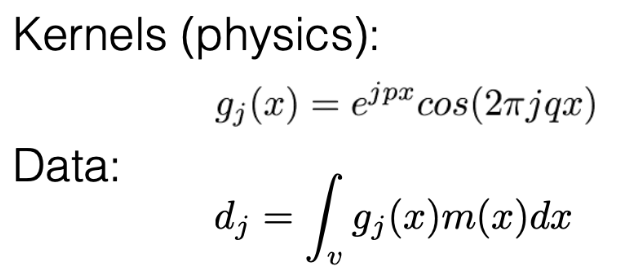

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.sparse as sp

In [2]:
def kernel_function(x, j, p, q): 
    return (
        np.exp(j * p * x) 
        * np.cos(2 * np.pi * j * q * x) 
    )

In [3]:
n_cells = 100
x_nodes = np.linspace(0, 1, n_cells+1)

In [4]:
n_kernels = 20 

p = -0.05
q = 0.1
j0 = 1
jN = 30

j_values = np.linspace(j0, jN, n_kernels)

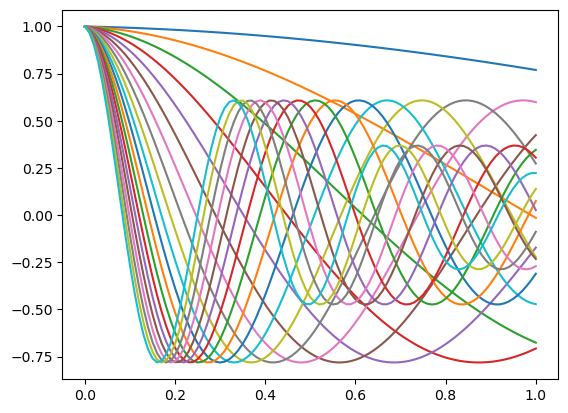

In [5]:
for jk in j_values: 
    g = kernel_function(x_nodes, j=jk, p=p, q=q)
    plt.plot(x_nodes, g)

In [6]:
delta_x = np.diff(x_nodes) #x_nodes[1:] - x_nodes[:-1]
x_centers = x_nodes[:-1] + delta_x / 2

(0.0, 0.5)

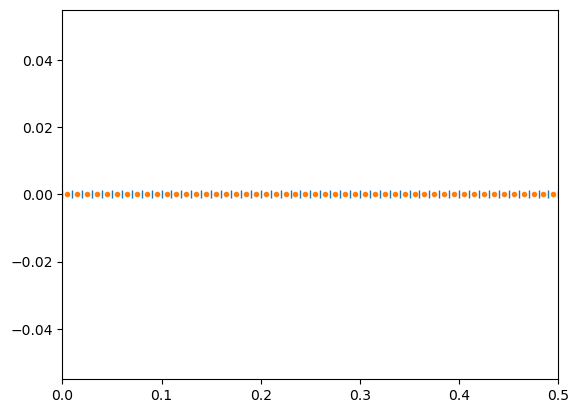

In [7]:
fig, ax = plt.subplots(1, 1)

ax.plot(x_nodes, np.zeros_like(x_nodes), "|")
ax.plot(x_centers, np.zeros_like(x_centers), ".")
ax.set_xlim([0, 0.5])

## define our model 
- boxcar and a gaussian 

In [8]:
def get_model(
    x_centers, 
    x_boxcar_min=0.15, x_boxcar_max=0.25, amplitude_boxcar=0.5,
    x0_gaussian=0.6, sigma_gaussian=0.05, amplitude_gaussian=0.4 
): 
    model = np.zeros_like(x_centers) 

    # boxcar
    inds_boxcar = (x_centers > x_boxcar_min) & (x_centers < x_boxcar_max)
    model[inds_boxcar] = amplitude_boxcar

    # define gaussian 
    def gaussian(x, x0, sigma): 
        return np.exp( - (x-x0)**2 / (2 * sigma**2))

    return model + amplitude_gaussian * gaussian(x_centers, x0_gaussian, sigma_gaussian) 

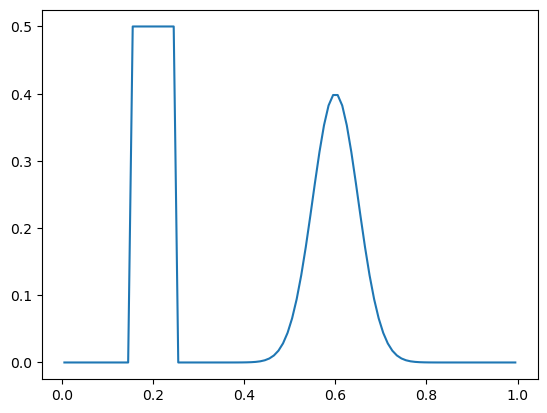

In [9]:
model = get_model(x_centers)
plt.plot(x_centers, model)

In [10]:
def get_G(x_nodes, n_kernels=20, p=-0.05, q=0.1, j0=1, jN=30):

    n_nodes = len(x_nodes)
    n_centers = n_nodes - 1

    j_values = np.linspace(j0, jN, n_kernels)
    
    # create an empty G 
    Gnodes = np.zeros((n_nodes, n_kernels))

    # fill with kernels 
    for k, jk in enumerate(j_values): 
        Gnodes[:, k] = kernel_function(x_nodes, j=jk, p=p, q=q)
        
    # averaging matrix 
    ave = sp.spdiags(0.5*np.vstack([np.ones(n_nodes), np.ones(n_nodes)]), [0, 1],m=n_centers, n=n_nodes)
    
    delta_x = np.diff(x_nodes)
    
    return (ave @ Gnodes).T @ sp.diags(delta_x)

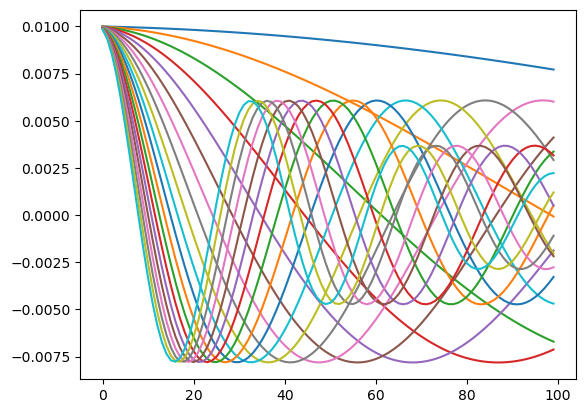

In [11]:
G = get_G(x_nodes)
plt.plot(G.T); 

In [12]:
m = get_model(
    x_centers, 
    x_boxcar_min=0.2, x_boxcar_max=0.25, amplitude_boxcar=0.7,
    x0_gaussian=0.6, sigma_gaussian=0.05, amplitude_gaussian=0.4 
)
G = get_G(x_nodes, n_kernels=20, p=-0.1, q=0.1, j0=1, jN=40)
d = G @ m

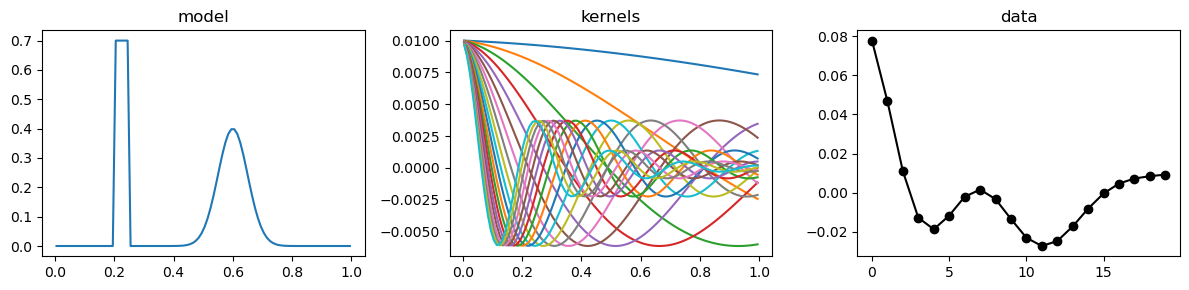

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(x_centers, m)
ax[1].plot(x_centers, G.T)
ax[2].plot(d, "-o", color="k")

ax[0].set_title("model")
ax[1].set_title("kernels")
ax[2].set_title("data")

plt.tight_layout()

In [14]:
A = G.T @ G 
rhs = G.T @ d

mrec = np.linalg.solve(A, rhs)

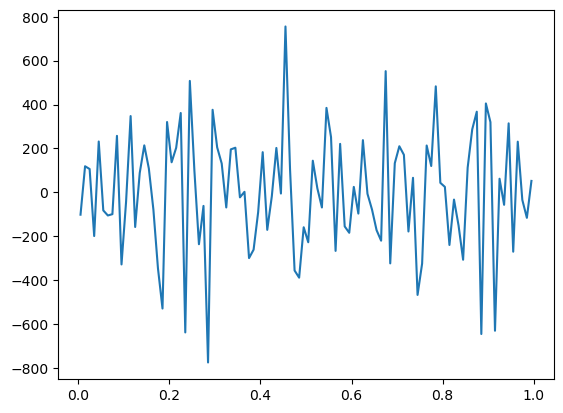

In [15]:
plt.plot(x_centers, mrec)

In [16]:
eigv, eig_vecotrs = np.linalg.eig(A)

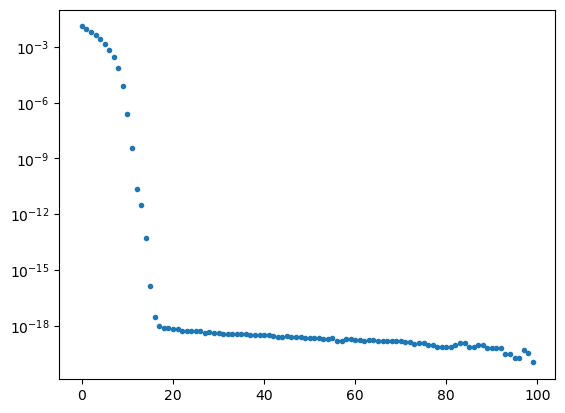

In [17]:
plt.semilogy(np.abs(eigv), ".")

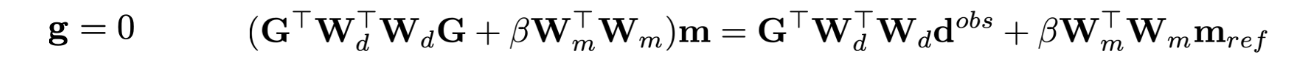

In [18]:
dobs = d # + gaussian noise

In [19]:
# std = 1e-4 
# Wd = 1/std * sp.eye(len(dobs))

In [20]:
# def get_H(beta, std=1e-4): 
# beta = 1e4
# mref = np.zeros_like(m) 

# Wd = 1/std * sp.eye(len(dobs))
# H = (G.T @ Wd.T @ Wd @ G + beta * Wm.T @ Wm) 
# rhs = G.T @ Wd.T @ Wd @ dobs + beta * Wm.T @ Wm @ mref

In [21]:
# mrec = np.linalg.solve(H, rhs)
# eig, eig_v = np.linalg.eig(H)
# plt.semilogy(np.abs(eig), '.')

In [22]:
def estimate_m(dobs, beta, std, mref=0):
    
    mref = mref * np.ones(len(x_centers))
    
    Wd = 1/std * sp.eye(len(dobs))
    
    Wm = sp.diags(np.sqrt(delta_x))
    
    H = (G.T @ Wd.T @ Wd @ G + beta * Wm.T @ Wm) 
    rhs = G.T @ Wd.T @ Wd @ dobs + beta * Wm.T @ Wm @ mref
    mrec = np.linalg.solve(H, rhs)
    
    rd = G @ mrec - dobs
    phid = rd.T @ Wd.T @ Wd @ rd
    
    rm = mrec - mref
    phim = rm.T @ Wm.T @ Wm @ rm
    
    return mrec, phid, phim

In [23]:
noise_level = 1e-2 
mtrue = get_model(x_centers)
d = G @ mtrue 

dobs = d + noise_level * np.random.randn(len(dobs))

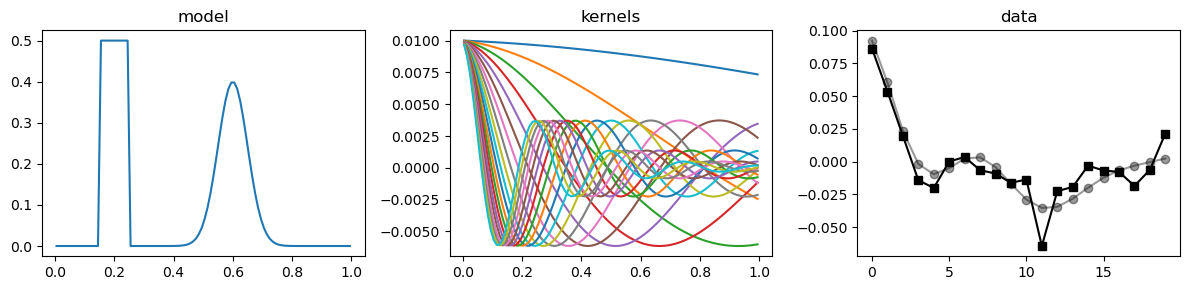

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(x_centers, mtrue)
ax[1].plot(x_centers, G.T)
ax[2].plot(d, "-o", color="k", label="clean", alpha=0.4)
ax[2].plot(dobs, "-s", color="k", label="dobs")

ax[0].set_title("model")
ax[1].set_title("kernels")
ax[2].set_title("data")

plt.tight_layout()

In [81]:
def plot_tikhonov_curves(iteration, beta_values, phid, phim, n_kernels, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))

    n_beta = len(beta_values) 
    
    ax[0].loglog(beta_values, phid)
    ax[1].loglog(beta_values, phim)
    ax[2].loglog(phim, phid)

    ax[0].loglog(beta_values[iteration], phid[iteration], "o", color="C3")
    ax[1].loglog(beta_values[iteration], phim[iteration], "o", color="C3")
    ax[2].loglog(phim[iteration], phid[iteration], "o", color="C3")

    ax[0].loglog(beta_values, n_kernels * np.ones(n_beta), "--k")

    ax[0].set_ylabel("$\\phi_d$")
    ax[1].set_ylabel("$\\phi_m$")

    ax[2].set_ylabel("$\\phi_d$")
    ax[2].set_xlabel("$\\phi_m$")

    for a in ax[:2]: 
        a.set_xlabel("$\\beta$")
        a.invert_xaxis()

    plt.tight_layout()
    return ax

In [82]:
def plot_recovered_model(iteration, x_centers, mtrue, mrec, G, dobs, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))

    ax[0].plot(x_centers, mtrue, label="true")
    ax[0].plot(x_centers, mrec[:, iteration], label="recovered")

    ax[1].plot(x_centers, G.T)

    dpred = G @ mrec[:, iteration]
    # ax[2].plot(d, "-o", color="k", label="clean", alpha=0.4)
    ax[2].plot(dobs, "-s", color="k", label="dobs")
    ax[2].plot(dpred, "-o", color="C3", label="dpred")

    ax[0].legend()
    ax[2].legend()

    ax[0].set_title("model")
    ax[1].set_title("kernels")
    ax[2].set_title("data")

    plt.tight_layout()
    
    return ax

In [27]:
import ipywidgets 

In [28]:
# todo: this is still broken 


In [83]:
n_beta = 100
std_tik = 0.5e-2

noise_level = 0.5e-2 
m_box_gaussian = get_model(x_centers)
dclean = G @ mtrue 

dobs_tik = dclean + noise_level * np.random.randn(len(dobs))

beta_values_tik = np.logspace(6, -6, n_beta)

mrec_tik = np.zeros((len(x_centers), n_beta))  # np.nan * np.ones(shape)
phid_tik = np.zeros(n_beta)
phim_tik = np.zeros(n_beta) 

for i, beta in enumerate(beta_values_tik): 
    mrec_tik[:, i], phid_tik[i], phim_tik[i] = estimate_m(dobs=dobs_tik, beta=beta, std=std_tik, mref=0)

In [84]:
def plot_inversion_results_widget(iteration=0): 
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    plot_tikhonov_curves(iteration, beta_values, phid, phim, n_kernels, ax=ax[0, :])
    plot_recovered_model(iteration, x_centers, mtrue, mrec, G, dobs, ax=ax[1, :])

In [85]:
ipywidgets.interact(
    plot_inversion_results_widget,
    iteration = ipywidgets.IntSlider(min=0, max=n_beta, value=0)
)


interactive(children=(IntSlider(value=0, description='iteration'), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_inversion_results_widget(iteration=0)>

# Inversion with SVD 

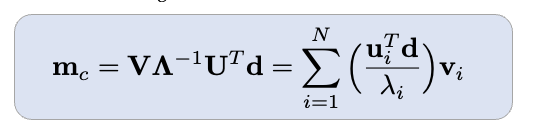

In [31]:
m = get_model(
    x_centers, 
    x_boxcar_min=0.2, x_boxcar_max=0.25, amplitude_boxcar=0.7,
    x0_gaussian=0.6, sigma_gaussian=0.05, amplitude_gaussian=0.4 
)
G = get_G(x_nodes, n_kernels=20, p=-0.1, q=0.1, j0=1, jN=40)
d = G @ m

noise_level = 0
dobs = d + noise_level * np.random.randn(len(d))

In [32]:
U, l, VT = np.linalg.svd(G, full_matrices=False)
V = VT.T

In [33]:
U.shape

(20, 20)

In [34]:
l.shape

(20,)

In [35]:
V.shape

(100, 20)

In [36]:
UTU = U.T @ U

In [37]:
from matplotlib.colors import LogNorm 

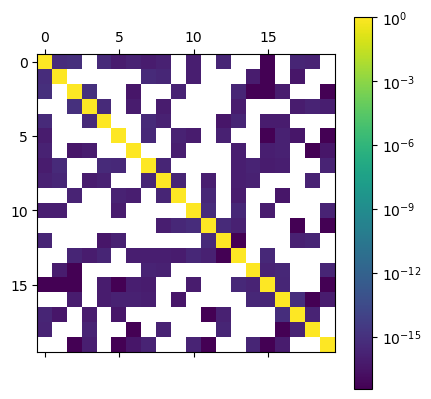

In [38]:
plt.colorbar(plt.matshow(V.T @ V, norm=LogNorm()))

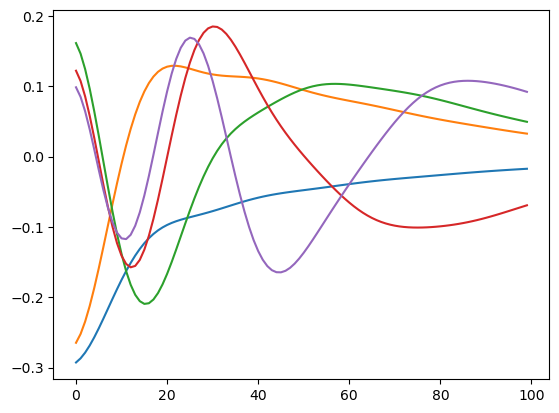

In [39]:
plt.plot(V[:, :5]);

In [40]:
l

array([1.10394340e-01, 9.45283301e-02, 7.92659757e-02, 6.47771034e-02,
       5.07547100e-02, 3.77788331e-02, 2.61729164e-02, 1.64622301e-02,
       8.45081759e-03, 2.69944259e-03, 4.87930232e-04, 5.83679609e-05,
       4.64449602e-06, 1.79127291e-06, 2.27628675e-07, 1.16215276e-08,
       4.05615357e-10, 2.50886677e-11, 3.10592077e-12, 6.67449297e-14])

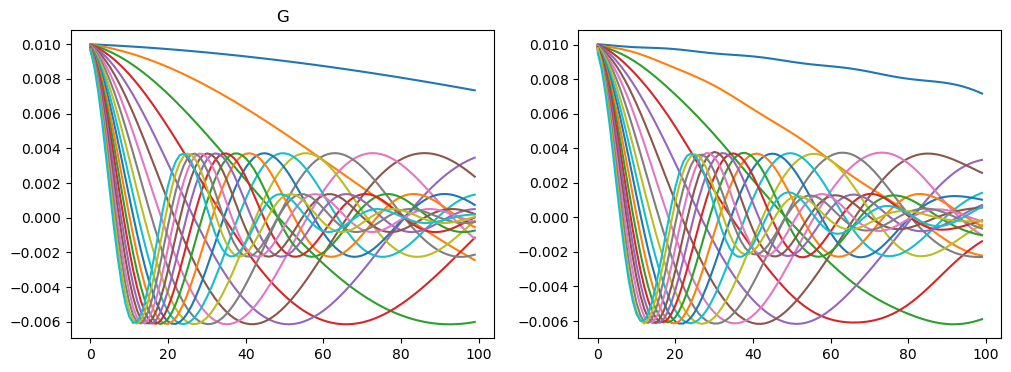

In [41]:
n_vec = 9
G_hat = U[:, :n_vec] @ np.diag(l[:n_vec]) @ V[:, :n_vec].T

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(G.T);
ax[0].set_title("G")

ax[1].plot(G_hat.T); 

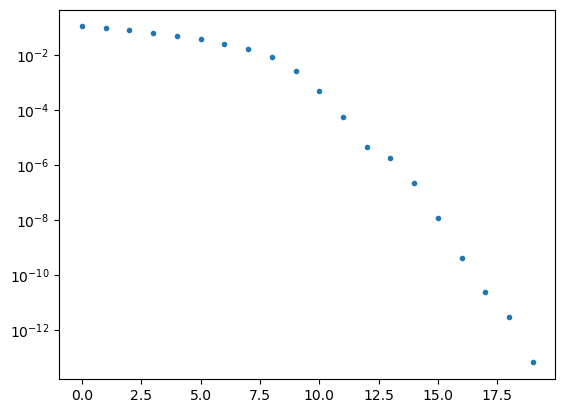

In [42]:
plt.semilogy(l, ".")

In [43]:
def get_m_at_index(index=0): 
    ud = U[:, index].T @ dobs
    return ud / l[index] * V[:, index]

In [44]:
def reconstruct_m_svd(n_vectors=1): 
    msvd = np.zeros_like(x_centers) 
    
    for i in range(n_vectors): 
        msvd = msvd + get_m_at_index(i)
    return msvd

In [47]:
# m0 = get_m_at_index(3)
# plt.plot(x_centers, mtrue)
# plt.plot(x_centers, reconstruct_m_svd(10))

In [48]:
# tmp = np.arange(3)
# tmp[slice(0, 1)]

In [49]:
def plot_svd_solution(n_vectors=1): 
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))

    index = n_vectors - 1

    msvd = reconstruct_m_svd(n_vectors)
    dpred = G @ msvd

    ax[0].semilogy(l, ".")
    ax[0].semilogy(l[:n_vectors], "C3o")
    ax[1].plot(get_m_at_index(slice(0,n_vectors)), color="k")
    ax[2].plot(x_centers, mtrue, label="true")
    ax[2].plot(x_centers, msvd, label="svd")

    ax[3].plot(dobs, "s", color="k")
    ax[3].plot(dpred, "-o", color="C3")


In [50]:
ipywidgets.interact(
    plot_svd_solution,
    n_vectors=ipywidgets.IntSlider(min=0, max=V.shape[1], value=0)
)

interactive(children=(IntSlider(value=0, description='n_vectors', max=20), Output()), _dom_classes=('widget-in…

<function __main__.plot_svd_solution(n_vectors=1)>

In [61]:
def get_m_weighted_svd(index=0, beta=0):
    ud = U[:, index].T @ dobs
    return (l[index])/(l[index]**2 + beta) * ud * V[:, index]

In [62]:
m0 = get_m_weighted_svd(index=0)
mprev = get_m_at_index(index=0)

In [64]:
# mprev

In [65]:
def reconstruct_m_weighted_svd(n_vectors=1, beta=0): 
    msvd = np.zeros_like(x_centers) 
    
    for i in range(n_vectors): 
        msvd = msvd + get_m_weighted_svd(i, beta)
    return msvd

In [75]:
def plot_weighted_svd_solution(n_vectors=1, beta=0): 
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))

    index = n_vectors - 1

    msvd = reconstruct_m_weighted_svd(n_vectors, beta)
    dpred = G @ msvd

    ax[0].semilogy(l, ".")
    if beta > 0:
        ax[0].semilogy(np.arange(n_kernels), beta*np.ones(n_kernels), "--k")
    ax[0].semilogy(l[:n_vectors], "C3o")
    ax[1].plot(get_m_weighted_svd(slice(0,n_vectors), beta=beta), color="k")
    ax[2].plot(x_centers, mtrue, label="true")
    ax[2].plot(x_centers, msvd, label="svd")

    ax[3].plot(dobs, "s", color="k")
    ax[3].plot(dpred, "-o", color="C3")


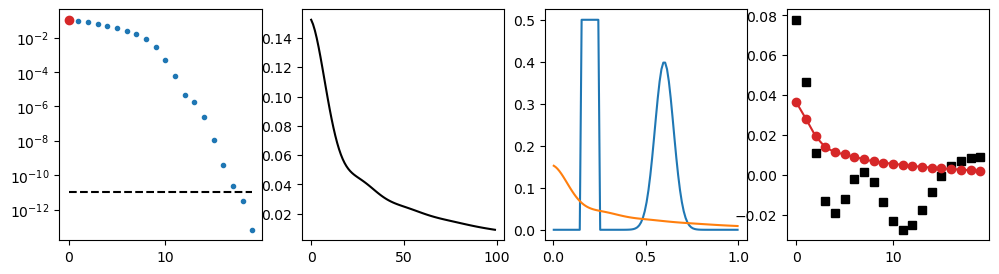

In [76]:
plot_weighted_svd_solution(1, 1e-11)

In [77]:
ipywidgets.interact(
    plot_weighted_svd_solution,
    n_vectors=ipywidgets.IntSlider(min=0, max=V.shape[1], value=0),
    beta=ipywidgets.FloatText(value=0)
)

interactive(children=(IntSlider(value=0, description='n_vectors', max=20), FloatText(value=0.0, description='b…

<function __main__.plot_weighted_svd_solution(n_vectors=1, beta=0)>

In [104]:
# for loop over a range of beta values, solve the svd solution, look at model, data, tikhonov curves

mtrue_svd = get_model(
    x_centers, 
    x_boxcar_min=0.2, x_boxcar_max=0.25, amplitude_boxcar=0.7,
    x0_gaussian=0.6, sigma_gaussian=0.05, amplitude_gaussian=0.4 
)
G = get_G(x_nodes, n_kernels=20, p=-0.1, q=0.1, j0=1, jN=40)
dclean_svd = G @ mtrue_svd

noise_level = 1e-2
dobs_svd = dclean_svd + noise_level * np.random.randn(len(dclean_svd))

n_beta = 50
beta_values_svd = np.logspace(0, -12, n_beta)

n_vectors = n_kernels 

mrec_weighted_svd = np.zeros((n_cells, n_beta))
dpred_svd = np.zeros((n_kernels, n_beta))
phid_svd = np.zeros(n_beta) 
phim_svd = np.zeros(n_beta) 

for i, beta in enumerate(beta_values_svd): 
    # get reconstructed m 
    mrec_weighted_svd[:, i] = reconstruct_m_weighted_svd(n_vectors=n_vectors, beta=beta)
    
    # compute predicted data 
    dpred_svd[:, i] = G @ mrec_weighted_svd[:, i]
    
    # phid
    rd = (1/noise_level) * (dpred_svd[:, i] - dobs_svd)
    phid_svd[i] = rd.T @ rd
    
    # phim 
    rm = np.sqrt(delta_x) * mrec_weighted_svd[:, i]
    phim_svd[i] = rm.T @ rm

In [105]:
def plot_svd_inversion_results_widget(iteration=0): 
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    plot_tikhonov_curves(iteration, beta_values_svd, phid_svd, phim_svd, n_kernels, ax=ax[0, :])
    plot_recovered_model(iteration, x_centers, mtrue_svd, mrec_weighted_svd, G, dobs_svd, ax=ax[1, :])

In [106]:
ipywidgets.interact(
    plot_svd_inversion_results_widget, 
    iteration=ipywidgets.IntSlider(min=0, max=n_beta, value=0)
)


interactive(children=(IntSlider(value=0, description='iteration', max=50), Output()), _dom_classes=('widget-in…

<function __main__.plot_svd_inversion_results_widget(iteration=0)>

In [64]:
beta = 1e-12
A = (V @ np.diag(l**2) @ V.T + beta * np.eye(n_cells))

In [65]:
eigs = np.linalg.eigvals(A)

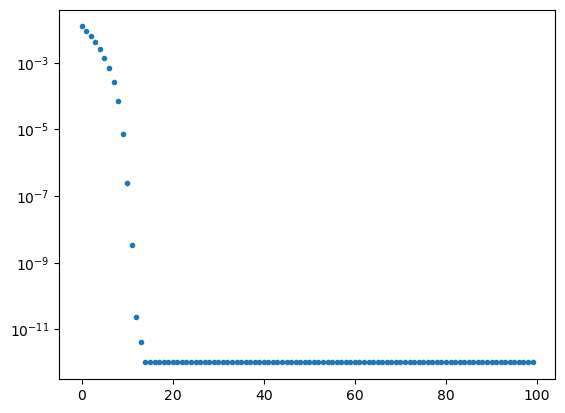

In [66]:
plt.semilogy(eigs, ".")